# 모두의 딥러닝
## 19장 세상에 없는 얼굴 GAN, 오토인코더

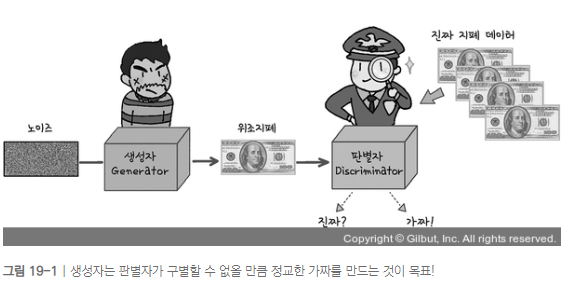

가짜를 만들어 내는 파트를 생성자(Generator)
진위를 가려내는 파트를 판별자(Discriminator) \

진짜 지폐와 똑같은 위조지폐를 만들기 위해 애쓰는 위조지폐범과
이를 가려내기 위해 노력하는 경찰 사이의 경합이
결국 더 정교한 위조지폐를 만들어 낸다는 것이
적대적경합 (GAN 알고리즘 내부에서 일어나는 일들)

### 생성적 적대 신경망(Generative Adversarial Networks, GAN(간))
- 딥러닝의 원리를 활용해 가상 이미지를 생성하는 알고리즘
- 한쪽은 가짜를 만들고, 한쪽은 진짜와 비교하는 경합 과정을 이용하여 더욱 정교한 가짜를 만들어냄(이것이 바로 GAN의 원리)
- 생성자(Generator): 가상의 이미지 생성
- 랜덤한 픽셀 값으로 채워진 가짜 이미지로 시작해서 판별자의 판별 결과에 따라 지속적으로 업데이트 하며 점차 원하는 이미지 생성
- 판별자(Discriminator): 생성자에서 넘어온 이미지의 진위 여부를 판별

### DCGAN(Deep Convolutional GAN)
- 컨볼루션 신경망(CNN)을 GAN에 적용한 알고리즘인 DCGAN 실습
- 판별과 학습이 생성자에서 일어나지 않기에 optimizer, compile 미사용

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

<< generator 모델 만들 시 참고 >>

- 7*7 크기의 이미지 채널 128개짜리 만들기 위해 가시적으로 식으로 표현
- activation=layers.LeakyReLU(0.2) : 0.2를 부여하기 위해
(activation='layers.LeakyReLU(0.2)' : default=0.3으로 실행됨)
x < 0, ReLU(x)=0 으로 불안정하고, 뉴런들이 일찍 소실되는 단점 보완
- padding='same' : 입력 크기 = 출력 크기, 다를 경우 크기를 확장하여 0을 채워줌 아래 생성자 모델의 경우 kernel_size=5이니 상하좌우 2줄씩 0으로 채워짐
- BatchNormalization : 입력 데이터의 평균=0, 분산=1 되도록 스케일링 해줌
다음 층으로 입력될 값을 일정하게 재배치하는 역할
- UpSampling2D: MaxPooling 정반대, 77 → 14 14로 확장
- 판별자로 넘겨주기 직전 tanh() => -1 < 출력(판별자 입력) < 1

In [4]:
generator = models.Sequential()

# LeakyReLU()는 0 밑으로 약간의 기울기를 넣어줄 수 있음
# 여기서는 임의로 0.2를 넣어줌
generator.add(layers.Dense(7*7*128, input_dim=100, 
                          activation=layers.LeakyReLU(0.2)))

# BatchNormalization()은 입력값을 0~1사이로 스케일링 해줌
# BatchNormalization()은 자체 파라미터가 있으므로 계산 놉
generator.add(layers.BatchNormalization())

generator.add(layers.Reshape((7, 7, 128)))

# UpSampling2D() 2배로 늘림
generator.add(layers.UpSampling2D())

# padding='same'은 7x7을 5x5로 줄일때 전체 크기는 7x7로 유지시킴
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))

generator.add(layers.BatchNormalization())

generator.add(layers.Activation(layers.LeakyReLU(0.2)))

generator.add(layers.UpSampling2D())

generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

- T(1)/F(0) 판별 -> 이진분류
- discriminator.trainable = False :
생성자가 noise를 던지면 순전파를 통해 판별자에게 넘어옴 판별자는 본인이 얻은 가중치, 오차를 본인이 학습하는데 사용X
생성자에게 넘겨주어 생성자 파라미터 갱신
판별자는 오류가 많은 noise로 학습하면 안되니 가중치를 저장하는 학습 기능 꺼주기
따로 학습시켜야함
- strides=2 :
기본은 1픽셀씩이지만 2픽셀씩 확인하겠다
(듬성듬성 특징을 뽑아내겠다, 계산량 줄어듬, 세밀함 줄어듬)
- 생성자의 출력수 = 판별자의 입력수 이므로 맞춰야 했지만 판별자는 T/F 판별만 하면 됨

In [6]:
# 가짜를 받는 판별자
discriminator = models.Sequential()

# strides=2 커널 윈도를 두칸씩 이동 (디폴트는 1씩 이동)
discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2, 
                         input_shape=(28,28,1), padding="same"))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))

# metrics=[]를 선언하지 않는 이유
# 판별자는 오차를 던져주기 위한 용도일뿐이기 때문에 최종결론을 표시해줄필요가없다
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# 기본 디폴트를 학습을 못하게 막음
# 판별자는 자신이 학습되지 않아야함 오직 판별만을 위한것
discriminator.trainable = False

In [7]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듬

ginput = layers.Input(shape=(100,))  # 임의의 100개 벡터를 Input() 통해 생성자에 입력할 ginput 생성
dis_output = discriminator(generator(ginput)) # 판별자가 입력 값을 판별한 값

# Model(입력, 출력)
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [8]:
# 신경망을 실행시키는 함수를 만듬

if not os.path.exists('data/gan_images'):
    os.mkdir('data/gan_images')
    
def gan_train(epoch, batch_size, saving_interval):
    # 앞서 불러온 MNIST를 다시 이용함. 테스트 과정은 필요 없고
    # 이미지만 사용할 것이기 때문에 X_train만 호출
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    
    # 225로 나누는게 아닌 127.5를 먼저 빼주고 127.5로 나눔
    # 결과는 0~1이 아닌 -1 ~1 사이가 나옴
    # 왜 이렇게 했느냐?
    # 생성자가 출력 값을 activation='tanh' 즉 -1에서 1사이로 주었기 때문에
    # 판별자의 X_train 값도 맞춰줘야함
    X_train = (X_train - 127.5) / 127.5
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분
        # randint(a, b, c)는 a에서 b사이를 c만큼 랜덤으로 뽑으라는 함수
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        # 판별자가 가짜가 아닌 진짜그림을 판별할때의 오차
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        
        # 가상 이미지를 판별자에 입력하는 부분
        # 0에서 1사이에서 batch_size만큼 100열의 noise를
        # random이 아닌 정규식으로 뽑음
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        # 판별자가 가짜그림을 판별할때의 오차
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 판별자와 생성자의 오차를 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        # 중간 과정을 이미지로 저장하는 부분 정해진 인터벌만큼 학습되면
        # 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 173ms/step
epoch:0  d_loss:0.7238  g_loss:0.4207
1/1 [==============================] - 0s 31ms/step
epoch:1  d_loss:0.5430  g_loss:0.1783
1/1 [==============================] - 0s 20ms/step
epoch:2  d_loss:0.5767  g_loss:0.1111
1/1 [==============================] - 0s 49ms/step
epoch:3  d_loss:0.5502  g_loss:0.1793
1/1 [==============================] - 0s 36ms/step
epoch:4  d_loss:0.4826  g_loss:0.4203
1/1 [==============================] - 0s 30ms/step
epoch:5  d_loss:0.4017  g_loss:0.8208
1/1 [==============================] - 0s 30ms/step
epoch:6  d_loss:0.4074  g_loss:1.1870
1/1 [==============================] - 0s 37ms/step
epoch:7  d_loss:0.4527  g_loss:1.3622
1/1 [==============================] - 0s 34ms/step
epoch:8  d_loss:0.7127  g_loss:1.1220
1/1 [==============================] - 0s 35ms/step
epoch:9  d_loss:0.9345  g_loss:0.6817
1/1 [==============================] - 0s 34ms/step
epoch:10  d_loss:0.9963  g_loss:0.4074
1/1 [===

epoch:89  d_loss:0.6780  g_loss:1.3728
1/1 [==============================] - 0s 30ms/step
epoch:90  d_loss:0.4677  g_loss:1.6718
1/1 [==============================] - 0s 29ms/step
epoch:91  d_loss:0.3659  g_loss:2.1430
1/1 [==============================] - 0s 30ms/step
epoch:92  d_loss:0.3394  g_loss:2.0721
1/1 [==============================] - 0s 29ms/step
epoch:93  d_loss:0.4760  g_loss:2.4717
1/1 [==============================] - 0s 31ms/step
epoch:94  d_loss:0.5429  g_loss:1.5113
1/1 [==============================] - 0s 30ms/step
epoch:95  d_loss:0.4573  g_loss:1.2463
1/1 [==============================] - 0s 28ms/step
epoch:96  d_loss:0.7057  g_loss:1.3241
1/1 [==============================] - 0s 29ms/step
epoch:97  d_loss:0.6908  g_loss:1.4955
1/1 [==============================] - 0s 38ms/step
epoch:98  d_loss:0.5840  g_loss:2.2589
1/1 [==============================] - 0s 29ms/step
epoch:99  d_loss:0.5192  g_loss:2.5284
1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 30ms/step
epoch:179  d_loss:0.5841  g_loss:2.1760
1/1 [==============================] - 0s 28ms/step
epoch:180  d_loss:0.4444  g_loss:2.2262
1/1 [==============================] - 0s 30ms/step
epoch:181  d_loss:0.5322  g_loss:2.0152
1/1 [==============================] - 0s 25ms/step
epoch:182  d_loss:0.6526  g_loss:2.0249
1/1 [==============================] - 0s 31ms/step
epoch:183  d_loss:0.7958  g_loss:1.8004
1/1 [==============================] - 0s 29ms/step
epoch:184  d_loss:0.7223  g_loss:1.7429
1/1 [==============================] - 0s 20ms/step
epoch:185  d_loss:0.6952  g_loss:1.9968
1/1 [==============================] - 0s 31ms/step
epoch:186  d_loss:0.6969  g_loss:2.1732
1/1 [==============================] - 0s 30ms/step
epoch:187  d_loss:0.6745  g_loss:2.0564
1/1 [==============================] - 0s 29ms/step
epoch:188  d_loss:0.8634  g_loss:1.5196
1/1 [==============================] - 0s 28ms/step
epoch:189  d_loss:0.7517  g_

1/1 [==============================] - 0s 29ms/step
epoch:356  d_loss:0.4588  g_loss:1.6682
1/1 [==============================] - 0s 28ms/step
epoch:357  d_loss:0.4625  g_loss:1.6063
1/1 [==============================] - 0s 29ms/step
epoch:358  d_loss:0.5197  g_loss:1.4057
1/1 [==============================] - 0s 25ms/step
epoch:359  d_loss:0.4447  g_loss:2.0769
1/1 [==============================] - 0s 29ms/step
epoch:360  d_loss:0.4385  g_loss:2.3253
1/1 [==============================] - 0s 19ms/step
epoch:361  d_loss:0.6101  g_loss:2.3796
1/1 [==============================] - 0s 29ms/step
epoch:362  d_loss:0.4720  g_loss:1.8789
1/1 [==============================] - 0s 29ms/step
epoch:363  d_loss:0.3575  g_loss:1.7261
1/1 [==============================] - 0s 29ms/step
epoch:364  d_loss:0.5153  g_loss:1.9222
1/1 [==============================] - 0s 24ms/step
epoch:365  d_loss:0.3253  g_loss:2.0099
1/1 [==============================] - 0s 28ms/step
epoch:366  d_loss:0.3494  g_

1/1 [==============================] - 0s 30ms/step
epoch:533  d_loss:0.2561  g_loss:2.9295
1/1 [==============================] - 0s 31ms/step
epoch:534  d_loss:0.1405  g_loss:2.7063
1/1 [==============================] - 0s 25ms/step
epoch:535  d_loss:0.2242  g_loss:2.5333
1/1 [==============================] - 0s 30ms/step
epoch:536  d_loss:0.2218  g_loss:2.8220
1/1 [==============================] - 0s 30ms/step
epoch:537  d_loss:0.1329  g_loss:3.3864
1/1 [==============================] - 0s 20ms/step
epoch:538  d_loss:0.1793  g_loss:3.6654
1/1 [==============================] - 0s 37ms/step
epoch:539  d_loss:0.3190  g_loss:2.6917
1/1 [==============================] - 0s 29ms/step
epoch:540  d_loss:0.3326  g_loss:2.5052
1/1 [==============================] - 0s 29ms/step
epoch:541  d_loss:0.2541  g_loss:2.5017
1/1 [==============================] - 0s 30ms/step
epoch:542  d_loss:0.2303  g_loss:2.7036
1/1 [==============================] - 0s 28ms/step
epoch:543  d_loss:0.2144  g_

1/1 [==============================] - 0s 33ms/step
epoch:710  d_loss:0.3458  g_loss:1.9985
1/1 [==============================] - 0s 34ms/step
epoch:711  d_loss:0.5253  g_loss:1.8140
1/1 [==============================] - 0s 34ms/step
epoch:712  d_loss:0.6152  g_loss:2.0057
1/1 [==============================] - 0s 32ms/step
epoch:713  d_loss:0.5113  g_loss:2.7275
1/1 [==============================] - 0s 32ms/step
epoch:714  d_loss:0.3781  g_loss:2.3976
1/1 [==============================] - 0s 31ms/step
epoch:715  d_loss:0.3927  g_loss:2.4340
1/1 [==============================] - 0s 44ms/step
epoch:716  d_loss:0.5804  g_loss:1.8846
1/1 [==============================] - 0s 33ms/step
epoch:717  d_loss:0.3119  g_loss:1.8506
1/1 [==============================] - 0s 29ms/step
epoch:718  d_loss:0.3084  g_loss:2.0393
1/1 [==============================] - 0s 30ms/step
epoch:719  d_loss:0.2923  g_loss:1.8660
1/1 [==============================] - 0s 30ms/step
epoch:720  d_loss:0.5128  g_

1/1 [==============================] - 0s 33ms/step
epoch:887  d_loss:0.3123  g_loss:1.7625
1/1 [==============================] - 0s 31ms/step
epoch:888  d_loss:0.3093  g_loss:1.9525
1/1 [==============================] - 0s 29ms/step
epoch:889  d_loss:0.3954  g_loss:2.1406
1/1 [==============================] - 0s 29ms/step
epoch:890  d_loss:0.3228  g_loss:2.3349
1/1 [==============================] - 0s 35ms/step
epoch:891  d_loss:0.3387  g_loss:2.5409
1/1 [==============================] - 0s 30ms/step
epoch:892  d_loss:0.3854  g_loss:2.1645
1/1 [==============================] - 0s 29ms/step
epoch:893  d_loss:0.2695  g_loss:2.3864
1/1 [==============================] - 0s 36ms/step
epoch:894  d_loss:0.4121  g_loss:1.9895
1/1 [==============================] - 0s 31ms/step
epoch:895  d_loss:0.3442  g_loss:1.8801
1/1 [==============================] - 0s 39ms/step
epoch:896  d_loss:0.3724  g_loss:1.8641
1/1 [==============================] - 0s 30ms/step
epoch:897  d_loss:0.3206  g_

1/1 [==============================] - 0s 17ms/step
epoch:1064  d_loss:0.2926  g_loss:2.2404
1/1 [==============================] - 0s 32ms/step
epoch:1065  d_loss:0.4211  g_loss:2.2750
1/1 [==============================] - 0s 44ms/step
epoch:1066  d_loss:0.2551  g_loss:2.3867
1/1 [==============================] - 0s 23ms/step
epoch:1067  d_loss:0.3270  g_loss:1.9520
1/1 [==============================] - 0s 27ms/step
epoch:1068  d_loss:0.3934  g_loss:1.9008
1/1 [==============================] - 0s 31ms/step
epoch:1069  d_loss:0.2583  g_loss:2.2089
1/1 [==============================] - 0s 30ms/step
epoch:1070  d_loss:0.4496  g_loss:2.6598
1/1 [==============================] - 0s 29ms/step
epoch:1071  d_loss:0.5062  g_loss:2.4888
1/1 [==============================] - 0s 30ms/step
epoch:1072  d_loss:0.2645  g_loss:2.6309
1/1 [==============================] - 0s 16ms/step
epoch:1073  d_loss:0.2906  g_loss:2.3170
1/1 [==============================] - 0s 15ms/step
epoch:1074  d_loss

epoch:1239  d_loss:0.3347  g_loss:1.7017
1/1 [==============================] - 0s 27ms/step
epoch:1240  d_loss:0.5621  g_loss:2.4392
1/1 [==============================] - 0s 28ms/step
epoch:1241  d_loss:0.5391  g_loss:2.4163
1/1 [==============================] - 0s 31ms/step
epoch:1242  d_loss:0.7434  g_loss:2.2796
1/1 [==============================] - 0s 21ms/step
epoch:1243  d_loss:0.5969  g_loss:1.7769
1/1 [==============================] - 0s 27ms/step
epoch:1244  d_loss:0.6763  g_loss:1.3511
1/1 [==============================] - 0s 38ms/step
epoch:1245  d_loss:0.6341  g_loss:1.8046
1/1 [==============================] - 0s 31ms/step
epoch:1246  d_loss:0.5765  g_loss:1.8131
1/1 [==============================] - 0s 30ms/step
epoch:1247  d_loss:0.4742  g_loss:2.4240
1/1 [==============================] - 0s 30ms/step
epoch:1248  d_loss:0.5517  g_loss:2.1764
1/1 [==============================] - 0s 27ms/step
epoch:1249  d_loss:0.4538  g_loss:1.9357
1/1 [========================

1/1 [==============================] - 0s 29ms/step
epoch:1328  d_loss:0.3252  g_loss:2.7109
1/1 [==============================] - 0s 30ms/step
epoch:1329  d_loss:0.3072  g_loss:2.4445
1/1 [==============================] - 0s 30ms/step
epoch:1330  d_loss:0.3648  g_loss:2.0484
1/1 [==============================] - 0s 29ms/step
epoch:1331  d_loss:0.3805  g_loss:2.2582
1/1 [==============================] - 0s 30ms/step
epoch:1332  d_loss:0.3180  g_loss:2.7033
1/1 [==============================] - 0s 27ms/step
epoch:1333  d_loss:0.2591  g_loss:3.0355
1/1 [==============================] - 0s 28ms/step
epoch:1334  d_loss:0.4036  g_loss:2.7413
1/1 [==============================] - 0s 30ms/step
epoch:1335  d_loss:0.4423  g_loss:2.2246
1/1 [==============================] - 0s 15ms/step
epoch:1336  d_loss:0.4382  g_loss:2.0267
1/1 [==============================] - 0s 19ms/step
epoch:1337  d_loss:0.4774  g_loss:1.9065
1/1 [==============================] - 0s 30ms/step
epoch:1338  d_loss

epoch:1415  d_loss:0.3424  g_loss:2.3608
1/1 [==============================] - 0s 38ms/step
epoch:1416  d_loss:0.4617  g_loss:2.0570
1/1 [==============================] - 0s 31ms/step
epoch:1417  d_loss:0.5397  g_loss:2.1364
1/1 [==============================] - 0s 30ms/step
epoch:1418  d_loss:0.3073  g_loss:2.4497
1/1 [==============================] - 0s 37ms/step
epoch:1419  d_loss:0.3078  g_loss:2.3747
1/1 [==============================] - 0s 31ms/step
epoch:1420  d_loss:0.4744  g_loss:1.8800
1/1 [==============================] - 0s 34ms/step
epoch:1421  d_loss:0.4895  g_loss:1.6767
1/1 [==============================] - 0s 37ms/step
epoch:1422  d_loss:0.4657  g_loss:1.8430
1/1 [==============================] - 0s 31ms/step
epoch:1423  d_loss:0.3785  g_loss:1.8283
1/1 [==============================] - 0s 22ms/step
epoch:1424  d_loss:0.3221  g_loss:2.1574
1/1 [==============================] - 0s 47ms/step
epoch:1425  d_loss:0.3287  g_loss:2.4513
1/1 [========================

1/1 [==============================] - 0s 17ms/step
epoch:1504  d_loss:0.5557  g_loss:1.6994
1/1 [==============================] - 0s 47ms/step
epoch:1505  d_loss:0.3150  g_loss:2.1101
1/1 [==============================] - 0s 31ms/step
epoch:1506  d_loss:0.3351  g_loss:1.9379
1/1 [==============================] - 0s 18ms/step
epoch:1507  d_loss:0.4279  g_loss:1.9417
1/1 [==============================] - 0s 30ms/step
epoch:1508  d_loss:0.3993  g_loss:1.9362
1/1 [==============================] - 0s 23ms/step
epoch:1509  d_loss:0.5790  g_loss:1.7286
1/1 [==============================] - 0s 26ms/step
epoch:1510  d_loss:0.2912  g_loss:2.1326
1/1 [==============================] - 0s 34ms/step
epoch:1511  d_loss:0.3025  g_loss:1.8961
1/1 [==============================] - 0s 31ms/step
epoch:1512  d_loss:0.4172  g_loss:2.2497
1/1 [==============================] - 0s 28ms/step
epoch:1513  d_loss:0.3339  g_loss:2.5602
1/1 [==============================] - 0s 29ms/step
epoch:1514  d_loss

epoch:1679  d_loss:0.3842  g_loss:1.8694
1/1 [==============================] - 0s 41ms/step
epoch:1680  d_loss:0.3353  g_loss:1.4435
1/1 [==============================] - 0s 43ms/step
epoch:1681  d_loss:0.6817  g_loss:1.8092
1/1 [==============================] - 0s 32ms/step
epoch:1682  d_loss:0.4310  g_loss:2.1070
1/1 [==============================] - 0s 31ms/step
epoch:1683  d_loss:0.3030  g_loss:2.1564
1/1 [==============================] - 0s 28ms/step
epoch:1684  d_loss:0.3527  g_loss:2.2483
1/1 [==============================] - 0s 27ms/step
epoch:1685  d_loss:0.5271  g_loss:1.7559
1/1 [==============================] - 0s 32ms/step
epoch:1686  d_loss:0.3918  g_loss:1.8237
1/1 [==============================] - 0s 30ms/step
epoch:1687  d_loss:0.4501  g_loss:1.8078
1/1 [==============================] - 0s 26ms/step
epoch:1688  d_loss:0.4403  g_loss:1.8869
1/1 [==============================] - 0s 31ms/step
epoch:1689  d_loss:0.2832  g_loss:2.2080
1/1 [========================

1/1 [==============================] - 0s 24ms/step
epoch:1768  d_loss:0.4739  g_loss:1.3601
1/1 [==============================] - 0s 30ms/step
epoch:1769  d_loss:0.5320  g_loss:1.3742
1/1 [==============================] - 0s 28ms/step
epoch:1770  d_loss:0.4641  g_loss:1.5690
1/1 [==============================] - 0s 29ms/step
epoch:1771  d_loss:0.4151  g_loss:1.6708
1/1 [==============================] - 0s 30ms/step
epoch:1772  d_loss:0.5146  g_loss:1.9041
1/1 [==============================] - 0s 28ms/step
epoch:1773  d_loss:0.4734  g_loss:1.9290
1/1 [==============================] - 0s 16ms/step
epoch:1774  d_loss:0.4793  g_loss:1.9093
1/1 [==============================] - 0s 31ms/step
epoch:1775  d_loss:0.5630  g_loss:1.7732
1/1 [==============================] - 0s 29ms/step
epoch:1776  d_loss:0.5282  g_loss:1.7266
1/1 [==============================] - 0s 39ms/step
epoch:1777  d_loss:0.4582  g_loss:1.4472
1/1 [==============================] - 0s 29ms/step
epoch:1778  d_loss

epoch:1855  d_loss:0.5307  g_loss:1.5435
1/1 [==============================] - 0s 24ms/step
epoch:1856  d_loss:0.5167  g_loss:1.2484
1/1 [==============================] - 0s 24ms/step
epoch:1857  d_loss:0.5978  g_loss:1.3526
1/1 [==============================] - 0s 36ms/step
epoch:1858  d_loss:0.4462  g_loss:1.5122
1/1 [==============================] - 0s 30ms/step
epoch:1859  d_loss:0.4575  g_loss:1.9796
1/1 [==============================] - 0s 30ms/step
epoch:1860  d_loss:0.5613  g_loss:1.6749
1/1 [==============================] - 0s 22ms/step
epoch:1861  d_loss:0.5217  g_loss:1.6127
1/1 [==============================] - 0s 24ms/step
epoch:1862  d_loss:0.3633  g_loss:1.8381
1/1 [==============================] - 0s 36ms/step
epoch:1863  d_loss:0.4670  g_loss:1.7854
1/1 [==============================] - 0s 28ms/step
epoch:1864  d_loss:0.4199  g_loss:1.5978
1/1 [==============================] - 0s 30ms/step
epoch:1865  d_loss:0.4144  g_loss:1.7400
1/1 [========================

1/1 [==============================] - 0s 17ms/step
epoch:1944  d_loss:0.4452  g_loss:1.8028
1/1 [==============================] - 0s 24ms/step
epoch:1945  d_loss:0.5594  g_loss:1.5899
1/1 [==============================] - 0s 27ms/step
epoch:1946  d_loss:0.5565  g_loss:1.5312
1/1 [==============================] - 0s 30ms/step
epoch:1947  d_loss:0.4964  g_loss:1.6111
1/1 [==============================] - 0s 20ms/step
epoch:1948  d_loss:0.4693  g_loss:1.6537
1/1 [==============================] - 0s 38ms/step
epoch:1949  d_loss:0.5475  g_loss:1.9974
1/1 [==============================] - 0s 30ms/step
epoch:1950  d_loss:0.3368  g_loss:2.1108
1/1 [==============================] - 0s 25ms/step
epoch:1951  d_loss:0.4864  g_loss:1.6718
1/1 [==============================] - 0s 27ms/step
epoch:1952  d_loss:0.6077  g_loss:1.5786
1/1 [==============================] - 0s 31ms/step
epoch:1953  d_loss:0.4223  g_loss:1.4861
1/1 [==============================] - 0s 18ms/step
epoch:1954  d_loss

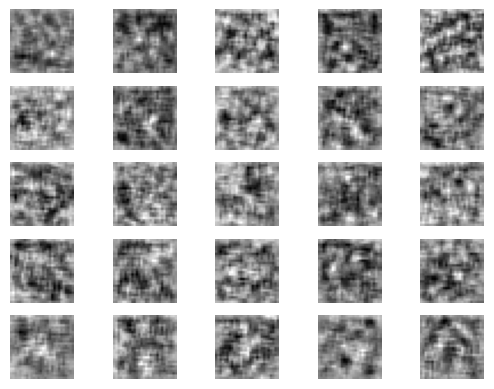

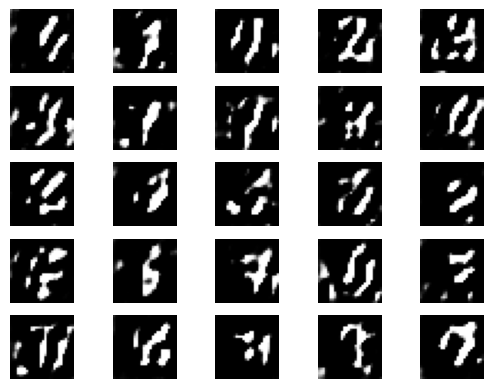

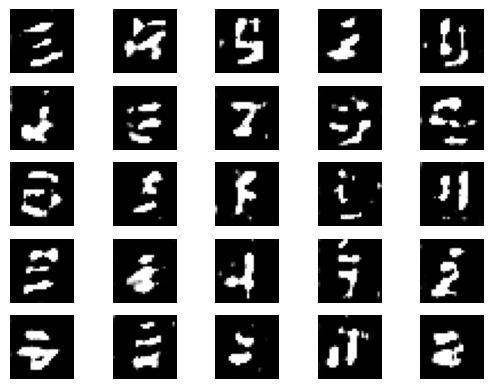

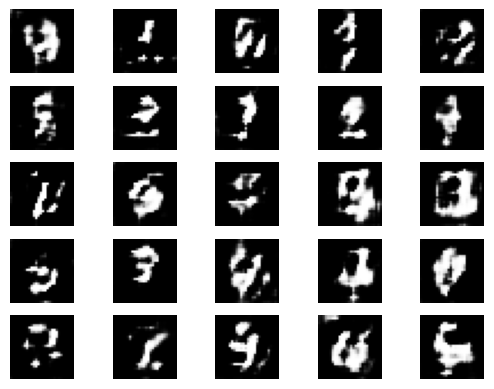

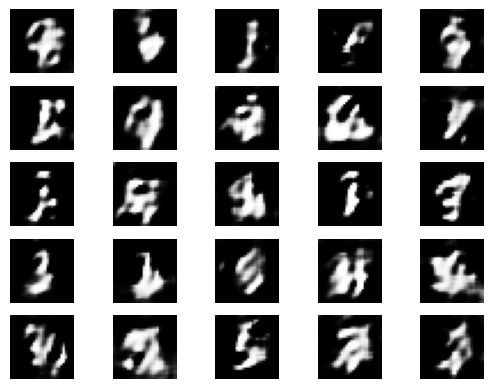

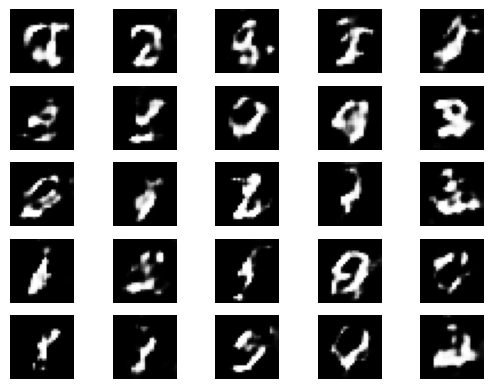

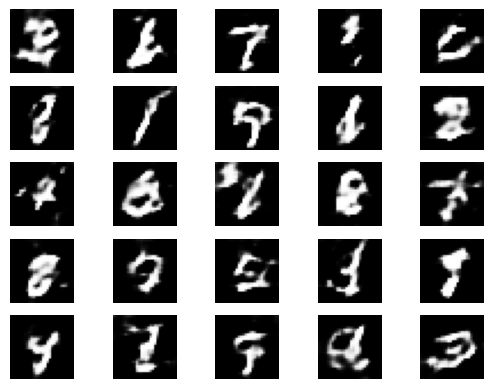

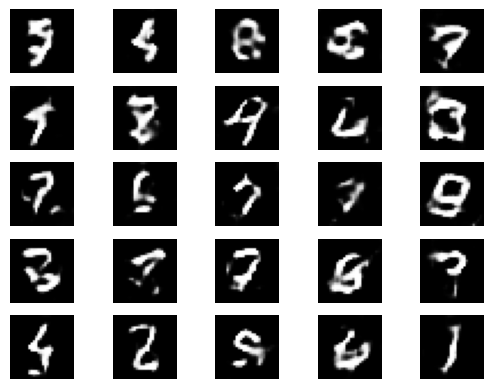

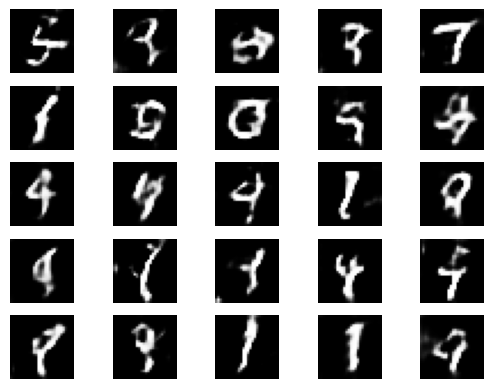

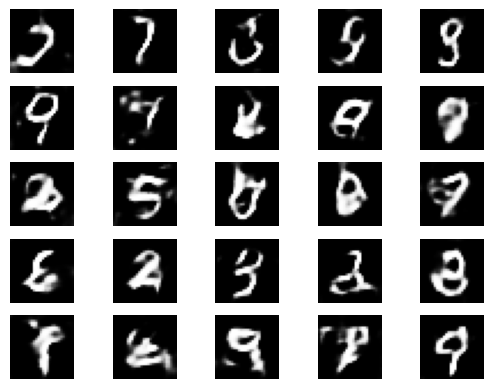

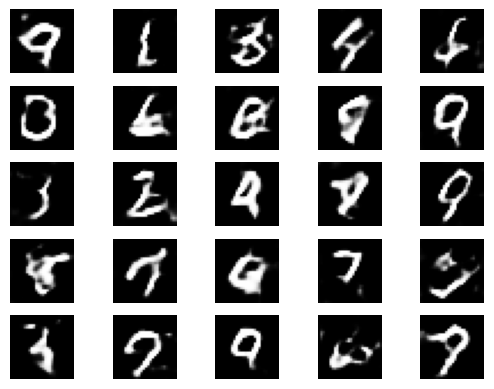

In [9]:
# 2000번 반복되고(+1을 하는 것에 주의)
# 배치 크기는 32, 200번마다 결과가 저장
gan_train(2001, 32, 200)

- 학습이 진행될수록 생성자가 만든 G(input)이 실제와 너무나 가까워져 이것으로 만든 D(G(input))과 실제 데이터로 만든 D(x)를 잘 구별하지 못하게 됨. 정확도가 0.5에 가까워질 때 생성자 학습 종료됨